In [ ]:
# homework 3 чат-бот

In [ ]:


#!pip install datasets
#!pip install nltk

#!pip install spacy
#python -m spacy download ru_core_news_sm

#!pip install gensim
#!pip install plotly
#!pip install umap
#!pip install python-telegram-bot

In [ ]:
#---------------------------------------------------------------------------------
#      загрузка диалогов
#---------------------------------------------------------------------------------

In [45]:
import pandas as pd

loaded_dataset_dialogs = pd.read_csv('chatbot-v3-dialogs.csv', sep=',')
loaded_dataset_dialogs = loaded_dataset_dialogs[::80]
loaded_dataset_dialogs = loaded_dataset_dialogs.reset_index(drop=True)

loaded_dataset_dialogs.head()
loaded_dataset_dialogs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4077 entries, 0 to 4076
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4077 non-null   object
 1   input   4077 non-null   object
 2   output  4077 non-null   object
dtypes: object(3)
memory usage: 95.7+ KB


In [85]:
import spacy

# формат: question, answer
def get_indent_from_dialogs(dialog_ds, nlp):
    all_words = []
    tags = []
    xy = []
    y = []

    i_len = len(dialog_ds)
    for row in dialog_ds.itertuples():
        doc = nlp(row.input.lower())
        tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and not token.is_punct]
        if tokens != []:
            tag = str('d_')+str(row.Index)
            tags.append(tag)
            all_words.extend(tokens)
            xy.append((tokens, tag))
            y.append((tag, row.output))
        if row.Index % 100 == 0:
            print(f"-> {row.Index}/{i_len}  ", end='\r', flush=True)

    print()
    return all_words, tags, xy, y

print('ok')

ok


In [86]:
from nltk.stem import SnowballStemmer
import spacy

nlp = spacy.load('ru_core_news_sm')

print(loaded_dataset_dialogs.info())

all_words, tags, xy, y = get_indent_from_dialogs(loaded_dataset_dialogs, nlp)

print(len(tags))
print(tags[1])
print(len(all_words))
print(all_words[1:20])
print(xy[1])
print(y[1])

print('ok')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4077 entries, 0 to 4076
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4077 non-null   object
 1   input   4077 non-null   object
 2   output  4077 non-null   object
dtypes: object(3)
memory usage: 95.7+ KB
None
-> 4000/4077  
3520
d_1
8403
['жаркий', 'четвёртый', 'первый', 'штурман', 'капитан', 'молчать', 'a', 'конь', 'дадите', 'восемь', 'ноль', 'ноль', 'разрешить', 'сегодня', 'отдельный', 'маленький', 'детство', 'мечтать', 'открыть']
(['четвёртый'], 'd_1')
('d_1', '- Все считаешь?')
ok


In [ ]:
# нейросеть

In [5]:
import torch
import torch.nn as nn

class NeuralNetWithBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetWithBatchNorm, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.relu2 = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.l2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.l3(out)
        return out

print('ok')

ok


In [ ]:
# функция формирования сумки слов

In [60]:
import nltk
import numpy as np
from nltk.stem.snowball import SnowballStemmer

def bag_of_words_2(tokenized_sentence, words):
    """
    Возвращает вектор "мешка слов" для предложения.
    """
    sentence_words = [word for word in tokenized_sentence]
    bag = np.zeros(len(words), dtype=np.float32)
    for idx, w in enumerate(words):
        if w in sentence_words:
            bag[idx] += 1
    return bag


def test_222():
    stemmer_222 = SnowballStemmer("russian")
    b = ["организовать", "организация", "организованный"]
    stemmed_words = [stemmer_222.stem(word) for word in b]
    print(stemmed_words)
    words = ["привет", "как", "дела", "ты"]
    sentence = ["привет", "у", "тебя", "как", "дела", "дела"]
    bag = bag_of_words_2(sentence, words)
    print(bag)


test_222()

['организова', 'организац', 'организова']
[1. 1. 1. 0.]


In [19]:
# делаем датасеты для обучения

In [114]:
import json
import numpy as np
import torch
import torch.nn as nn
from itertools import islice

print('sort')
tags_sorted = sorted(set(tags))

print('for')
X_train = []
y_train = []
xy_len = len(xy)

for xy_idx, (pattern_sentence, tag) in enumerate(xy):
    bag = bag_of_words_2(pattern_sentence, all_words)
    X_train.append(bag)

    label = tags_sorted.index(tag)
    y_train.append(label)

    if xy_idx % 100 == 0:
        print(f"-> {xy_idx}/{xy_len}  ", end='\r', flush=True)

print()
print('X_train')
X_train = np.array(X_train)
y_train = np.array(y_train)

print(tags_sorted[1])
print(all_words[1:20])
print(xy[1])
print(y[1])
print(X_train)

print('ok')

sort
for
-> 3500/3520  
X_train
d_1
['жаркий', 'четвёртый', 'первый', 'штурман', 'капитан', 'молчать', 'a', 'конь', 'дадите', 'восемь', 'ноль', 'ноль', 'разрешить', 'сегодня', 'отдельный', 'маленький', 'детство', 'мечтать', 'открыть']
(['четвёртый'], 'd_1')
('d_1', '- Все считаешь?')
[[1. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]
ok


In [ ]:
# датасет для обучения

In [89]:
from torch.utils.data import Dataset, DataLoader

class ChatDataset(Dataset):
    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = torch.from_numpy(X_train).float()
        self.y_data = torch.from_numpy(y_train).long()

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples

print('ok')

ok


In [ ]:
# функция вычисления accuracy

In [63]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

print('ok')

ok


In [ ]:
# используем GPU

In [3]:
import torch

print(torch.cuda.is_available())  # Должно вернуть True, если GPU доступен
print(torch.cuda.device_count())  # Количество доступных GPU
print(torch.cuda.get_device_name(0))  # Название первого GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
1
NVIDIA GeForce GTX 1650
cuda


In [2]:
# имя файла для сохранения модели
FILE = "chatbot-v3-nndata.pth"

In [ ]:
# Гиперпараметры

In [66]:
# Гиперпараметры
batch_size = 8
hidden_size = 256
output_size = len(tags)
input_size = len(all_words)
learning_rate = 0.0001

print(len(tags))
len(all_words)

4077


8403

In [ ]:
# train

In [117]:
epochs = 100

In [118]:
dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

model = NeuralNetWithBatchNorm(input_size, hidden_size, output_size).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
train_accuracy = []
train_precision = []

print('ok')

ok


In [ ]:
# Обучение модели

In [123]:
from sklearn.metrics import precision_score



log("Начало обучения модели...")
model.train()
for epoch in range(epochs):
    total_loss = 0
    total_accuracy = 0
    num_batches = 0
    all_predicted = []
    all_labels = []
    
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(device)

        outputs = model(words)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        accuracy = calculate_accuracy(outputs, labels)
        total_accuracy += accuracy
        num_batches += 1

        _, predicted = torch.max(outputs, dim=1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches
    precision = precision_score(all_labels, all_predicted, average='weighted', zero_division=0)
    
    print(f'Эпоха [{epoch+1}/{epochs}], loss: {avg_loss:.8f} accuracy: {avg_accuracy:.8f} precision: {precision:.8f}', end = '\r', flush = True)
    
    train_losses.append(avg_loss)
    train_accuracy.append(avg_accuracy)
    train_precision.append(precision)
    
    if (epoch + 1) % 50 == 0:
        print(f'Эпоха [{epoch+1}/{epochs}], avg loss: {avg_loss:.8f} avg accuracy {avg_accuracy:.8f} precision: {precision:.8f}   ', flush = True)
    
print()

log("Обучение завершено.")

Начало обучения модели...
Эпоха [50/100], avg loss: 0.26492840 avg accuracy 0.87414773 precision: 0.86486742   
Эпоха [100/100], avg loss: 0.25532519 avg accuracy 0.87500000 precision: 0.86541193   

Обучение завершено.


In [ ]:
# сохранение модели в файл

In [121]:
data = {
    "model_state": model.state_dict(),
    "input_size": input_size,
    "output_size": output_size,
    "hidden_size": hidden_size,
    "all_words": all_words,
    "tags": tags,
    "y" : y,
    "xy": xy,
    "train_losses": train_losses,
    "train_accuracy": train_accuracy,
    "train_precision": train_precision

}

torch.save(data, FILE)

log(f"Модель сохранена в {FILE}")

Модель сохранена в chatbot-v3-nndata.pth


In [ ]:
# графики обучения

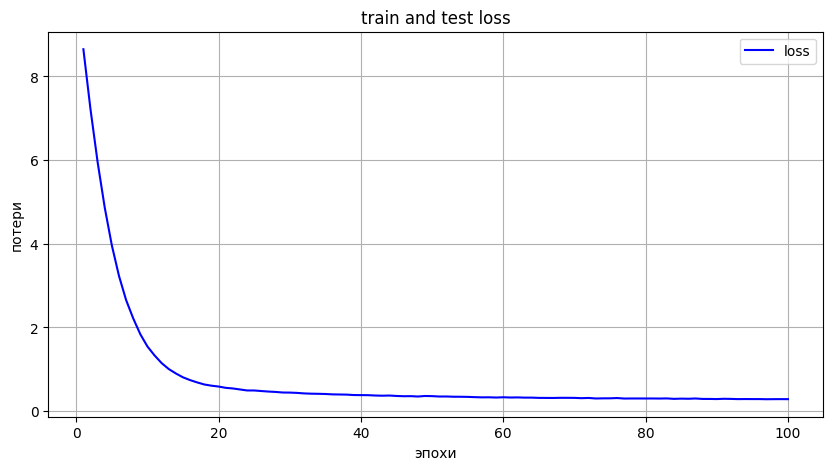

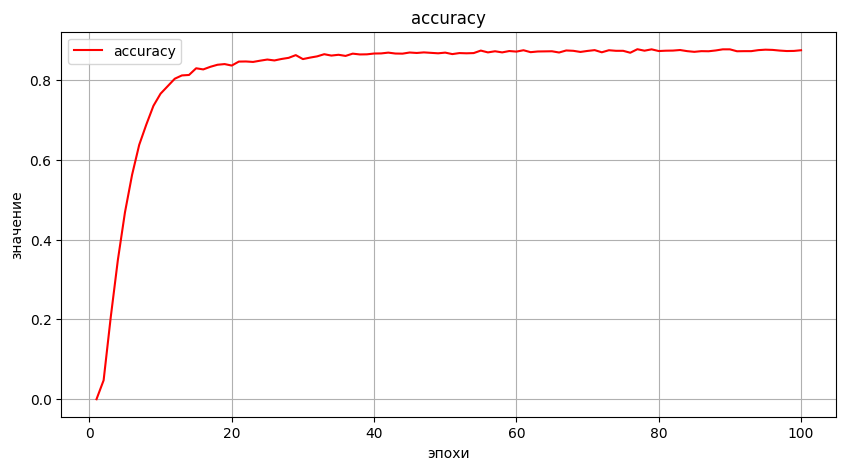

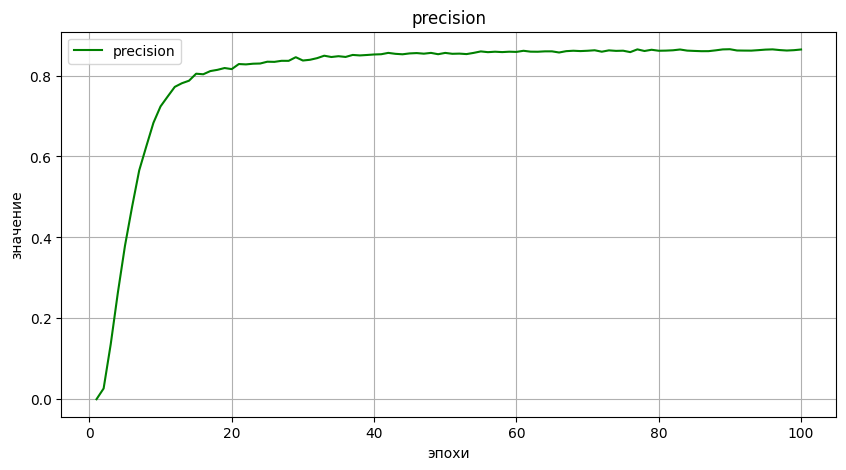

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

    
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='loss', color='blue')
#plt.plot(range(1, epochs + 1), torch.stack(test_losses).cpu(), label='test', color='orange')
plt.title('train and test loss')
plt.xlabel('эпохи')
plt.ylabel('потери')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='accuracy', color='red')
plt.title('accuracy')
plt.xlabel('эпохи')
plt.ylabel('значение')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_precision) + 1), train_precision, label='precision', color='green')
plt.title('precision')
plt.xlabel('эпохи')
plt.ylabel('значение')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# загрузка сохраненной модели

In [6]:
import torch

data = torch.load(FILE)

input_size = data["input_size"]
hidden_size = data["hidden_size"]
output_size = data["output_size"]
all_words = data["all_words"]
tags = data["tags"]
model_state = data["model_state"]
y = data["y"]
xy = data["xy"]

train_losses = data["train_losses"]
train_accuracy = data["train_accuracy"]
train_precision = data["train_precision"]

model = NeuralNetWithBatchNorm(input_size, hidden_size, output_size).to(device)
model.load_state_dict(model_state)
model.eval()

print('ok')

ok


In [ ]:
# chat

In [122]:
from nltk.stem import SnowballStemmer
import spacy

model.eval()

nlp_chat = spacy.load('ru_core_news_sm')
stemmer_chat = SnowballStemmer("russian")

def tokenize_chat(sentence):
    tokens_chat = []
    doc_chat = nlp_chat(sentence.lower())
    log(f'doc_chat: {doc_chat}')
    token_chat = [token.lemma_ for token in doc_chat if token.is_alpha and not token.is_stop]
    tokens_chat.extend(token_chat)
    log(f'tokens_chat: {tokens_chat}')
    return tokens_chat



bot_name = "ЧатБот"
print("Давайте поговорим! (наберите 'выйти' для завершения)")

while True:
    print()
    sentence = input("Вы: ")
    if sentence in ("выйти", "q", "й") or len(sentence) == 0:
        break

    sentence = tokenize_chat(sentence)
    print(f'tokenized sentence: {sentence}')
    X = bag_of_words_2(sentence, all_words)
    print(X)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).float().to(device)

    output = model(X)
    _, predicted = torch.max(output, dim=1)
    print(f'predicted {predicted.item()}')

    tag = tags[predicted.item()]
    
    for wxy in xy:
        if wxy[1] == str(tag):
            print(f'xy: {wxy}')
    
    probs = torch.softmax(output, dim=1)
    prob = probs[0][predicted.item()]
    print(f'prob: {prob} tag: {tag}')
    if prob.item() > 0.0:
        for answ in y:
            if tag == answ[0]:
                response = answ[1]
                print(f"{bot_name}: {response}")
                break
    else:
        print(f"{bot_name}: Я не совсем понял...")

print('ok')

Давайте поговорим! (наберите 'выйти' для завершения)



Вы:  привет мопед


doc_chat: привет мопед
tokens_chat: ['привет', 'мопед']
tokenized sentence: ['привет', 'мопед']
[0. 0. 0. ... 0. 0. 0.]
predicted 851
xy: (['парень'], 'd_1020')
prob: 0.34024232625961304 tag: d_1020
ЧатБот: - Да, хи, мы друзья.



Вы:  какие мы друзья?


doc_chat: какие мы друзья?
tokens_chat: ['друг']
tokenized sentence: ['друг']
[0. 0. 0. ... 0. 0. 0.]
predicted 3476
xy: (['извергнуть', 'любить'], 'd_4029')
prob: 0.9361853003501892 tag: d_4029
ЧатБот: - Ой, подруга, да просто я вчера нацепила сережки в виде комаров!



Вы:  комары слетелись на твои сережки?


doc_chat: комары слетелись на твои сережки?
tokens_chat: ['комар', 'слететься', 'серёжка']
tokenized sentence: ['комар', 'слететься', 'серёжка']
[0. 0. 0. ... 0. 0. 0.]
predicted 471
xy: (['здравствуй', 'свиданья'], 'd_573')
prob: 0.9998576641082764 tag: d_573
ЧатБот: - Можем.



Вы:  и что ты можешь


doc_chat: и что ты можешь
tokens_chat: []
tokenized sentence: []
[0. 0. 0. ... 0. 0. 0.]
predicted 426
xy: (['джордж', 'делать'], 'd_519')
prob: 0.017569035291671753 tag: d_519
ЧатБот: - Расти руку!



Вы:  рука у меня нужной длины не то что твоя


doc_chat: рука у меня нужной длины не то что твоя
tokens_chat: ['рука', 'нужный', 'длина']
tokenized sentence: ['рука', 'нужный', 'длина']
[0. 0. 0. ... 0. 0. 0.]
predicted 1064
xy: (['обыгрывать'], 'd_1271')
prob: 0.46054530143737793 tag: d_1271
ЧатБот: - Кого?



Вы:  того не выеживайся


doc_chat: того не выеживайся
tokens_chat: ['выеживайся']
tokenized sentence: ['выеживайся']
[0. 0. 0. ... 0. 0. 0.]
predicted 426
xy: (['джордж', 'делать'], 'd_519')
prob: 0.017569035291671753 tag: d_519
ЧатБот: - Расти руку!



Вы:  тупень ты какойто


doc_chat: тупень ты какойто
tokens_chat: ['тупень', 'какойто']
tokenized sentence: ['тупень', 'какойто']
[0. 0. 0. ... 0. 0. 0.]
predicted 426
xy: (['джордж', 'делать'], 'd_519')
prob: 0.017569035291671753 tag: d_519
ЧатБот: - Расти руку!



Вы:  трам парарам


doc_chat: трам парарам
tokens_chat: ['трам', 'парарам']
tokenized sentence: ['трам', 'парарам']
[0. 0. 0. ... 0. 0. 0.]
predicted 426
xy: (['джордж', 'делать'], 'd_519')
prob: 0.017569035291671753 tag: d_519
ЧатБот: - Расти руку!



Вы:  расскажи анекдот


doc_chat: расскажи анекдот
tokens_chat: ['рассказать', 'анекдот']
tokenized sentence: ['рассказать', 'анекдот']
[0. 0. 0. ... 0. 0. 0.]
predicted 2041
xy: (['жора', 'давать', 'поменяемся', 'жена'], 'd_2440')
prob: 0.8362827301025391 tag: d_2440
ЧатБот: - Фима, но у меня нет жены!



Вы:  улетела в тимбухту?


doc_chat: улетела в тимбухту?
tokens_chat: ['улететь', 'тимбухту']
tokenized sentence: ['улететь', 'тимбухту']
[0. 0. 0. ... 0. 0. 0.]
predicted 766
xy: (['ослепну'], 'd_922')
prob: 0.9999064207077026 tag: d_922
ЧатБот: - Мама не ослепнет?



Вы:  не ослепнет


doc_chat: не ослепнет
tokens_chat: ['ослепнуть']
tokenized sentence: ['ослепнуть']
[0. 0. 0. ... 0. 0. 0.]
predicted 2656
xy: (['дело'], 'd_3117')
prob: 0.0401516854763031 tag: d_3117
ЧатБот: - Принимайте на передержку троих дамбасян.



Вы:  


ok
